In [1]:
import os,cv2
import numpy as np
import json
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time

### Load data

In [2]:
with open('Data/train/train.json') as f:
  subjects = json.load(f)[400:405]

### Load models

#### Selective search segmentation

In [3]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#### AlexNet

In [4]:
alexnet = models.alexnet()
alexnet.classifier = nn.Sequential(*list(alexnet.classifier[:6]))
alexnet.load_state_dict(torch.load('Model/alexnet.pth'))

<All keys matched successfully>

#### SVM classifiers

In [5]:
svm1 = pickle.load(open('Model/svm1.sav', 'rb'))
svm2 = pickle.load(open('Model/svm2.sav', 'rb'))

|numeric|label|
|------|------|
|0|background|
|1|uninfected|
|2|infected|

#### Ridge regression models

In [6]:
reg_tx = pickle.load(open('Model/reg_tx.sav', 'rb'))
reg_ty = pickle.load(open('Model/reg_ty.sav', 'rb'))
reg_tw = pickle.load(open('Model/reg_tw.sav', 'rb'))
reg_th = pickle.load(open('Model/reg_th.sav', 'rb'))

### Define functions

In [7]:
## --------------------------
## Compute IoU
## --------------------------
def get_iou(bb1, bb2):
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou


## --------------------------
## Transformation for G and P
## --------------------------

def P_transform(bbx):
    x,y,w,h = bbx
    # x,y,w,h
    return(np.array([x+w/2,y+h/2,float(w),float(h)]))

def G_transform(bbx):
    x1,x2,y1,y2 = bbx['x1'],bbx['x2'],bbx['y1'],bbx['y2']
    # x,y,w,h
    return(np.array([(x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)]))


## ----------------------------------
## Data loader for alexnet input
## ----------------------------------

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
 transforms.ToTensor(),
 transforms.Normalize(
 mean,std)])

def data_loader(X,y):
    d_ts = [transform(x) for x in X]
    d_ls = []
    for i in range(len(d_ts)):
        d_ls.append([d_ts[i],int(y[i])])
    loader = DataLoader(dataset = d_ls,batch_size=1,shuffle=False)
    return(loader)


## --------------------------
##  Region proposal
## --------------------------
def region(subject,image):
    rects = subject['objects']
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssrects = ss.process()
    ssrects = ssrects[np.random.RandomState(seed=1).permutation(len(ssrects))[:6000]]
    imout = image.copy()
    
    G,P,regions,true_labels = [],[],[],[]
    
    for j in range(len(rects)):
        box = rects[j]['bbx']
        true_labels.append((rects[j]['category']=='infected')+1)
        iou = np.array([get_iou(box,{"x1":x,"x2":x+w,"y1":y,"y2":y+h}) for x,y,w,h in ssrects])
        ind = np.argmax(iou)
        iou = np.max(iou)
            
        p = ssrects[ind]
        x,y,w,h = p
        region = cv2.resize(imout[y:y+h,x:x+w], (224,224), interpolation = cv2.INTER_AREA)
        
        G.append(G_transform(box))
        P.append(P_transform(p))
        regions.append(region.astype(float)/225)
    
    G,P = np.array(G),np.array(P)
    
    return(G,P,regions,true_labels)


## --------------------------
##  SVM classification: get predicted labels
## --------------------------

def svm_clf(Phi):
    predicted_labels = []

    for i in range(len(Phi)):
        phi = Phi[i].reshape([1,4096])
        uninfect = int(svm1.predict(phi))
        infect = int(svm2.predict(phi))
        
        if (uninfect==0) and (infect==0):
            predicted_labels.append(0)
        else:
            predicted_labels.append((infect==1)+1)
    
    return predicted_labels



## ----------------------------------
## Get predicted ground truth boxes 
## ----------------------------------

def BBR(g,p,phi):
    t_x,t_y,t_w,t_h = reg_tx.predict(phi),reg_ty.predict(phi),reg_tw.predict(phi),reg_th.predict(phi)
    
    p = pd.DataFrame(p,columns=['x','y','w','h'])
    
    G_x = (np.array(p['w']).reshape([len(p),1])*t_x+np.array(p['x']).reshape([len(p),1])).flatten()
    G_y = (np.array(p['h']).reshape([len(p),1])*t_y+np.array(p['y']).reshape([len(p),1])).flatten()
    G_w = (np.array(p['w']).reshape([len(p),1])*np.exp(t_w)).flatten()
    G_h = (np.array(p['h']).reshape([len(p),1])*np.exp(t_h)).flatten()
    
    G_hat = np.array([np.array([g_x,g_y,g_w,g_h]).round(1) for g_x,g_y,g_w,g_h in zip(G_x,G_y,G_w,G_h)])
    
    return(G_hat)


## --------------
## Label image
## --------------

def label_image(image,G_hat,IoU,true_labels,predicted_labels):
    labels = np.array(['uninfect','infect'])

    ind_t = np.where(true_labels==predicted_labels)[0]
    ind_f = np.where(true_labels!=predicted_labels)[0]
    
    for i in range(len(ind_t)):
        ind = ind_t[i]
        g_hat = G_hat[ind]
        label = predicted_labels[ind]
        cv2.rectangle(image,(int(g_hat[0]-g_hat[2]/2),int(g_hat[1]-g_hat[3]/2)),
                      (int(g_hat[0]+g_hat[2]/2),int(g_hat[1]+g_hat[3]/2)),(0,255,0), 3)
        
    for j in range(len(ind_f)):
        ind = ind_f[j]
        g_hat = G_hat[ind]
        label = predicted_labels[ind]
        cv2.rectangle(image,(int(g_hat[0]-g_hat[2]/2),int(g_hat[1]-g_hat[3]/2)),
                      (int(g_hat[0]+g_hat[2]/2),int(g_hat[1]+g_hat[3]/2)),(255,0,0), 3)
        
    plt.figure(figsize=(10,10))
    for i in range(len(G_hat)):
        g_hat = G_hat[i]
        iou = IoU[i]
        label = predicted_labels[i]
        plt.text(g_hat[0]-g_hat[2]/2,g_hat[1],s=labels[label-1]+'\n'+str(iou),wrap=True,color='blue')
        
    plt.imshow(image)

#### Main function

In [8]:
def object_detection(subject):
    
    start_time = time.time()
    
    ## --------------------------
    ##  Region proposal
    ## --------------------------

    path = 'Data/train'+subject['image']['pathname']
    image = cv2.imread(path)
    
    G,P,regions,true_labels = region(subject,image)
    
    ## --------------------------
    ##  Feature extraction
    ## --------------------------
    
    torch.manual_seed(1)
    data = data_loader(regions,range(len(regions)))
    
    Phi = []
    alexnet.eval()
    for feature,label in data:
      Phi.append(np.array(alexnet(feature.float()).detach().numpy()).reshape([4096]))
    
    Phi = np.array(Phi)
    
    ## --------------------------
    ##  SVM classification
    ## --------------------------
    
    predicted_labels = svm_clf(Phi)
    true_labels, predicted_labels = np.array(true_labels), np.array(predicted_labels)
    
    ind = np.where(predicted_labels!=0)[0]
    acc_back = np.sum(predicted_labels==true_labels)/len(true_labels)
    acc_cell = np.sum(predicted_labels[ind]==true_labels[ind])/ind.shape[0]
    
    meta_matrix = pd.DataFrame({'uninfected':[np.sum( (true_labels==1)*(predicted_labels==1) ),
                                              np.sum( (true_labels==1)*(predicted_labels==2) )],
                                'infected':  [np.sum( (true_labels==2)*(predicted_labels==1) ),
                                              np.sum( (true_labels==2)*(predicted_labels==2) )]},
                              index = ['uninfected','infected'])
    
    true_labels, predicted_labels = true_labels[ind], predicted_labels[ind]
    
    ## --------------------------
    ##  Bouding box regression
    ## --------------------------
    G,P,Phi = G[ind],P[ind],Phi[ind]
    G_hat = BBR(G,P,Phi)
    
    IoU = np.array([get_iou({"x1":(g1[0]-g1[2]/2),"x2":(g1[0]+g1[2]/2),"y1":(g1[1]-g1[3]/2),"y2":(g1[1]+g1[3]/2)},
                            {"x1":(g2[0]-g2[2]/2),"x2":(g2[0]+g2[2]/2),"y1":(g2[1]-g2[3]/2),"y2":(g2[1]+g2[3]/2)}) 
                    for g1,g2 in zip(G,G_hat)]).round(2)
    
    
    ## ---------------------
    ## Outcome
    ## ---------------------
    print('Accuracy on the whole image: %.2f%%' % ((acc_back)*100))
    print('Accuracy on the boxes set: %.2f%%' % ((acc_cell)*100))
    print('\n')
    print(meta_matrix)
    print('\n')
    
    label_image(image,G_hat,IoU,true_labels,predicted_labels)
    print('Time cost: %.2f s' % ((time.time() - start_time)))

### Object detection

Accuracy on the whole image: 48.08%
Accuracy on the boxes set: 75.76%


            uninfected  infected
uninfected          25         0
infected             8         0


Time cost: 63.76 s


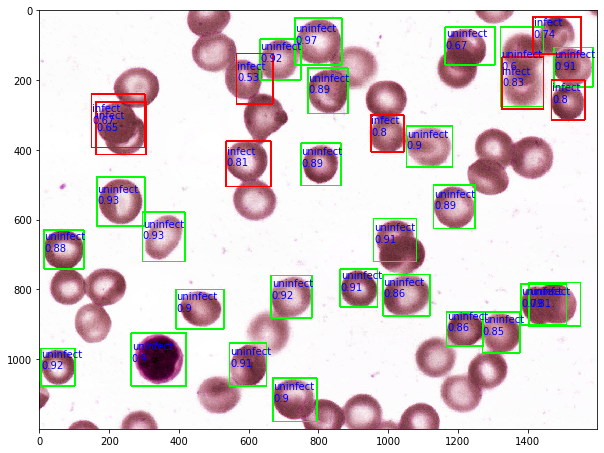

In [9]:
object_detection(subjects[0])

Accuracy on the whole image: 35.80%
Accuracy on the boxes set: 80.56%


            uninfected  infected
uninfected          28         0
infected             7         1


Time cost: 55.83 s


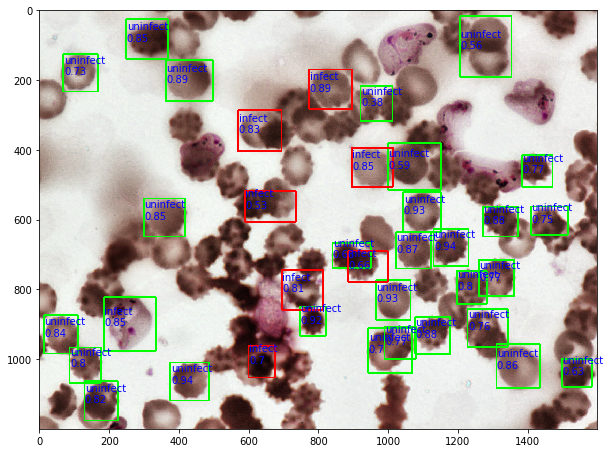

In [10]:
object_detection(subjects[1])

Accuracy on the whole image: 91.67%
Accuracy on the boxes set: 95.65%


            uninfected  infected
uninfected          22         1
infected             0         0


Time cost: 37.47 s


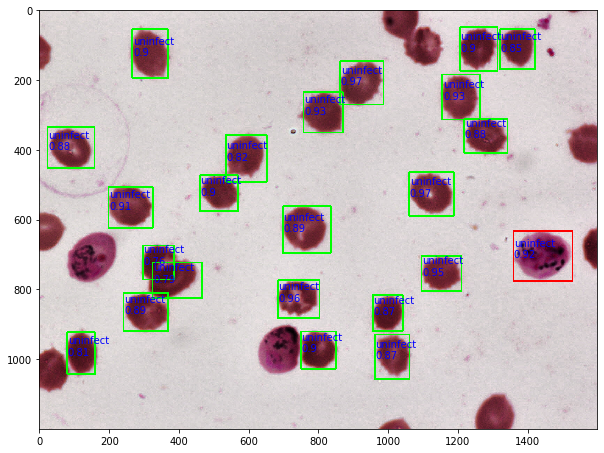

In [11]:
object_detection(subjects[2])

Accuracy on the whole image: 63.16%
Accuracy on the boxes set: 100.00%


            uninfected  infected
uninfected          24         0
infected             0         0


Time cost: 31.67 s


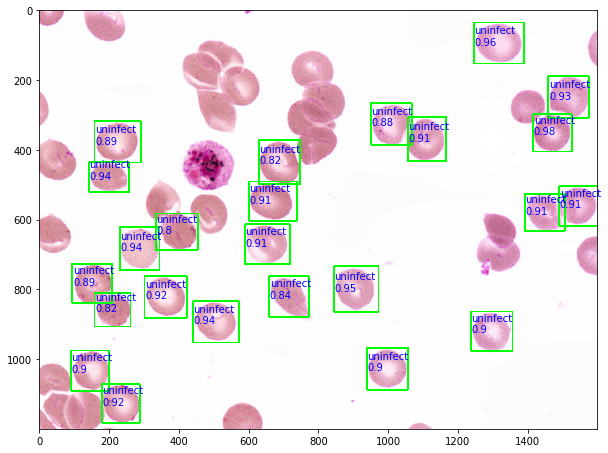

In [12]:
object_detection(subjects[3])

Accuracy on the whole image: 60.29%
Accuracy on the boxes set: 83.67%


            uninfected  infected
uninfected          39         1
infected             7         2


Time cost: 54.39 s


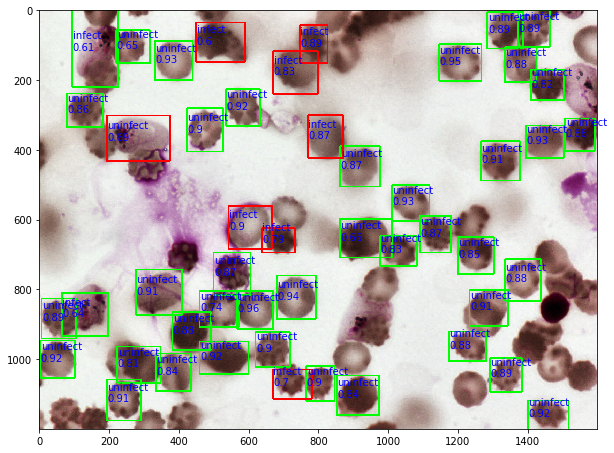

In [13]:
object_detection(subjects[4])